In [73]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [74]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [75]:
reduction = 1

img_width = int(8/reduction)
img_height = int(600/reduction)

In [76]:
image_names = []
path = pathlib.Path(r'O:\eve_models\training_data\route_y')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [77]:
random.shuffle(image_names)

In [78]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox'][1:2]
image_data[list(image_data.keys())[0]]

[377]

In [79]:
def convert_to_baw(img, thresh=80):
    fn = lambda x: 255 if x > thresh else 0
    return img.convert('L').point(fn, mode='1')

In [80]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.8), int(len(image_names)*0.9)])

In [81]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        #img = convert_to_baw(img)
        img = img.crop((132, 0, 140, 600))
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((132, 0, 140, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((132, 0, 140, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    test_x.append(np.array(img))
    
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 273.95it/s]


In [82]:
train_x[0].shape

(600, 8, 3)

In [83]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name])

train_y = np.array(train_y) / np.array([600])
val_y = np.array(val_y) / np.array([600])
test_y = np.array(test_y) / np.array([600])

100%|████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 175472.91it/s]


In [84]:
index = 30
img = Image.fromarray(train_x[index])
truth = (train_y[index] * np.array([600])) 
img1 = ImageDraw.Draw(img)  
img1.line([(0,truth[0]),(img_width,truth[0])], fill ="Green", width=2)
img

In [85]:
# measures of dispersion
min_ = np.amin(train_y)
max_ = np.amax(train_y)
range_ = np.ptp(train_y)
variance = np.var(train_y)
sd = np.std(train_y)
 
#print("Array =", train_y)
print("Measures of Dispersion")
print("Minimum =", min_)
print("Maximum =", max_)
print("Range =", range_)
print("Variance =", variance)
print("Standard Deviation =", sd)

Measures of Dispersion
Minimum = 0.3383333333333333
Maximum = 0.8283333333333334
Range = 0.49000000000000005
Variance = 0.018181863241282056
Standard Deviation = 0.13484013957750882


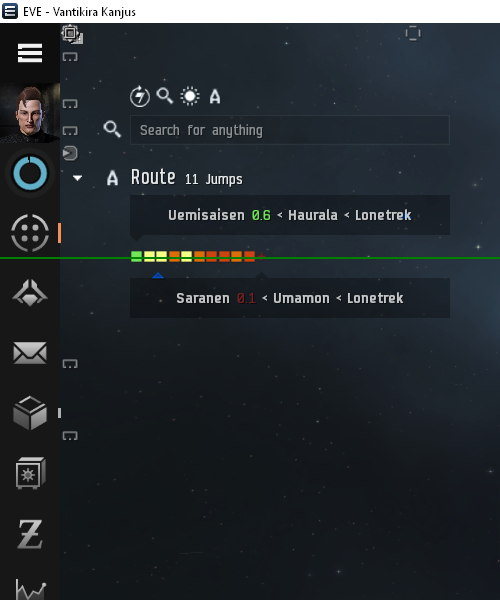

In [86]:
index = 20
img = Image.open(f"{path}\\{train_names[index]}")
truth = (train_y[index] * np.array([600])) # reduction
img1 = ImageDraw.Draw(img)  
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img

In [143]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    #layers.Resizing(img_height, img_width, interpolation='bilinear', crop_to_aspect_ratio=False),
    #layers.Normalization(input_shape=(img_height, img_width, 3)),
    #vgg,
    #layers.GlobalAveragePooling2D(),
    #layers.Conv2D(4, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(8, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(16, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.SpatialDropout2D(0.2),
    #layers.GlobalAvgPool2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.SpatialDropout2D(0.2),
    #layers.MaxPooling2D(),
    #layers.Conv2D(64, 3, activation='relu'),
    #layers.SpatialDropout2D(0.2),
    #layers.MaxPooling2D(),
    #layers.Conv2D(128, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(256, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(512, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.MaxPooling2D(2),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.MaxPooling2D(2),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(3, 3, activation='relu'),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #layers.Dense(units=512, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(units=256, activation='relu'),
    #layers.Dropout(0.1),
    layers.Dense(units=32, activation="relu"),
    #layers.Dropout(0.1),
    layers.Dense(units=1, activation='sigmoid')  
])


epochs = 1000
lr = 1e-4

callbacks = [
    ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.9, patience=10, min_lr=1e-10, verbose=1),
    #lr_finder,
    EarlyStopping(monitor='val_root_mean_squared_error', patience=100, restore_best_weights=False),
]

#model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.mae, metrics=['accuracy', 'mse', 'mae'])
model.compile(optimizer=Adam(lr), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.losses.MeanSquaredError()])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=128,
    shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)



Epoch 1/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - mean_squared_error: 0.0242 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112 - val_mean_squared_error: 0.0119 - lr: 1.0000e-04
Epoch 2/1000
11/11 [==============================] - 0s 12ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069 - mean_squared_error: 0.0114 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912 - val_mean_squared_error: 0.0082 - lr: 1.0000e-04
Epoch 3/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.0076 - root_mean_squared_error: 0.0869 - mean_squared_error: 0.0076 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746 - val_mean_squared_error: 0.0054 - lr: 1.0000e-04
Epoch 4/1000
11/11 [==============================] - 0s 4ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - mean_squared_error: 0.0057 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795 - val_mean_squared_error: 0.0061 - lr: 1.00

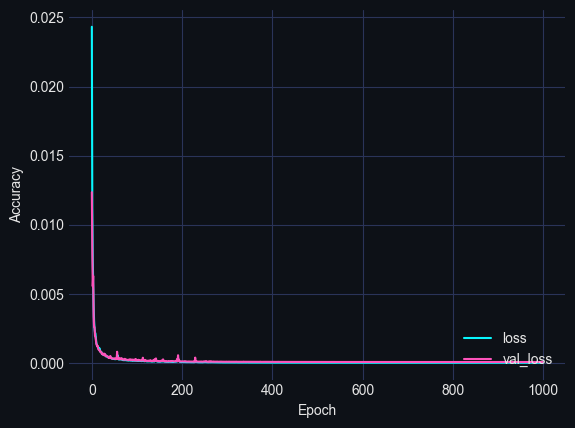

In [144]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

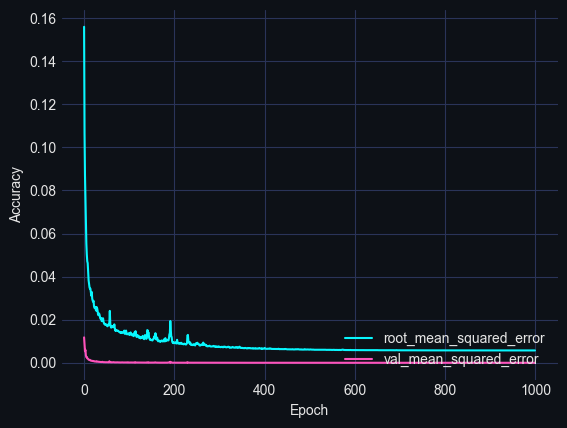

In [145]:
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [146]:
model2 = tf.keras.Model(inputs=model.inputs , outputs=model.layers[0].output)
prediction = model2.predict(np.array([test_x[test_image_index]]))
prediction[0]

1/1 [==============================] - 0s 25ms/step


array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.08235294, 0.10196079, 0.1137255 ],
        [0.08235294, 0.10196079, 0.1137255 ],
        [0.08235294, 0

1/1 [==============================] - 0s 15ms/step
[207.03865886]
[209.]


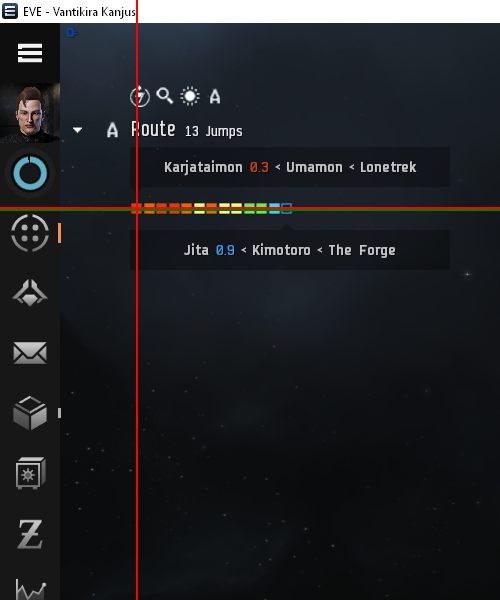

In [157]:
test_image_index = 150

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([600])) # reduction
result = result[0]
print(result)
truth = (test_y[test_image_index] * np.array([600])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img

In [311]:
model.save('test_location.h5')